## Install TensorTrade

In [2]:
#!python3 -m pip install git+https://github.com/tensortrade-org/tensortrade.git
import inspect
import sys
import os
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, "{}".format(parentdir))
currentdir

'd:\\MyWork\\StocksTrading\\Sandboxes\\AutoTrader\\tensortrade\\examples'

## Setup Data Fetching

In [3]:
import pandas as pd
import tensortrade.env.default as default

from tensortrade.data.cdd import CryptoDataDownload
from tensortrade.feed.core import Stream, DataFeed
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC, ETH, AAPL
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.agents import DQNAgent
from tensortrade.env.default.renderers import PlotlyTradingChart, FileLogger, MatplotlibTradingChart

import gym
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpPolicy, MlpLnLstmPolicy
from stable_baselines import DQN, PPO2, A2C

%matplotlib inline

# Use these commands - to reload sources, while development
%load_ext autoreload
%autoreload 2

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



2020-10-31 18:05:24,675 [DEBUG : utils.py: 53 ]: Logger is created
2020-10-31 18:05:24,685 [DEBUG : data_feed.py: 96 ]: Loading quotes from a file: D:\MyWork\StocksTrading\Sandboxes\AutoTrader\data\stock_data\AAPL_1D_2010-1-1_2020-9-9.csv
2020-10-31 18:05:24,992 [DEBUG : utils.py: 22 ]: utils.data_feed.QuotesLoader.get_quotes: took 0.3068 sec


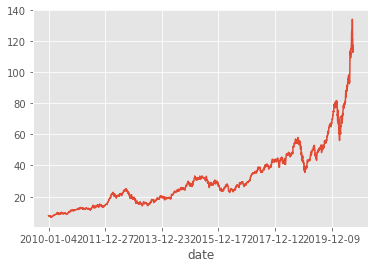

In [4]:
# Use Data-Feed from Yahoo Finance
sys.path.insert(0, "{}".format("D:\MyWork\StocksTrading\Sandboxes\AutoTrader"))
from utils import YahooQuotesLoader


exchange = 'NASDAQ'
quotes = YahooQuotesLoader.get_quotes(
        symbol='AAPL',
        date_from='2010-1-1',
        date_to='2020-9-9',
    )
quotes.drop(columns=["index","unnamed: 0","adj close"],inplace=True)
quotes.set_index("date",inplace=True)
quotes['close'].plot()

In [5]:

import ta
import numpy as np
# get ta-indicators
quotes_ta = ta.add_all_ta_features(quotes,"open","high","low","close","volume",fillna=True)

# convert to pct
data = quotes_ta.pct_change(fill_method ='ffill')
data = data.replace([np.inf, -np.inf], np.nan)
data = data.fillna(value=0)
data.reset_index(inplace=True)
data.tail()

,date,high,low,open,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
2685,2020-09-02,0.023590,-0.027044,0.036381,-0.020718,0.312513,-0.001561,-0.011487,-0.162758,-0.344312,...,-0.063573,-0.242292,-0.023087,8.259273,0.013461,0.005936,-0.126400,-1.520137,-1.536001,-0.021970
2686,2020-09-03,-0.066241,-0.051181,-0.077622,-0.080061,0.287232,-0.009214,-0.014958,-0.622834,-1.639461,...,-0.207466,-0.608730,-0.236250,1.698061,-0.057639,-0.000655,-0.685958,2.864234,2.985837,-0.085005
2687,2020-09-04,-0.039894,-0.079751,-0.053896,0.000662,0.291179,0.007560,0.019607,1.129998,-0.165838,...,0.135751,0.290623,-0.300544,-0.117566,-0.132978,-0.000984,-0.013461,-1.008267,-1.007928,0.000707
2688,2020-09-08,-0.038076,0.016142,-0.050970,-0.067295,-0.304385,-0.008716,-0.013377,-0.591707,1.807016,...,-0.107393,-0.808342,-0.476317,0.478261,-0.210144,-0.009532,-2.016008,-102.680369,-106.298166,-0.071834
2689,2020-09-09,0.001261,0.022897,0.029048,0.039887,-0.238108,0.000434,0.010330,0.775014,-0.435436,...,0.060689,2.331606,-0.069306,-0.178855,-0.320085,-0.002354,0.229056,-1.592712,-1.561414,0.042785


## Create features with the feed module

In [6]:
features = []
for c in data.columns[1:]:
    s = Stream.source(list(data[c]), dtype="float").rename(data[c].name)
    features += [s]
feed = DataFeed(features)
feed.compile()
for i in range(5):
    print(feed.next())

{'high': 0.0, 'low': 0.0, 'open': 0.0, 'close': 0.0, 'volume': 0.0, 'volume_adi': 0.0, 'volume_obv': 0.0, 'volume_cmf': 0.0, 'volume_fi': 0.0, 'momentum_mfi': 0.0, 'volume_em': 0.0, 'volume_sma_em': 0.0, 'volume_vpt': 0.0, 'volume_nvi': 0.0, 'volume_vwap': 0.0, 'volatility_atr': 0.0, 'volatility_bbm': 0.0, 'volatility_bbh': 0.0, 'volatility_bbl': 0.0, 'volatility_bbw': 0.0, 'volatility_bbp': 0.0, 'volatility_bbhi': 0.0, 'volatility_bbli': 0.0, 'volatility_kcc': 0.0, 'volatility_kch': 0.0, 'volatility_kcl': 0.0, 'volatility_kcw': 0.0, 'volatility_kcp': 0.0, 'volatility_kchi': 0.0, 'volatility_kcli': 0.0, 'volatility_dcl': 0.0, 'volatility_dch': 0.0, 'trend_macd': 0.0, 'trend_macd_signal': 0.0, 'trend_macd_diff': 0.0, 'trend_sma_fast': 0.0, 'trend_sma_slow': 0.0, 'trend_ema_fast': 0.0, 'trend_ema_slow': 0.0, 'trend_adx': 0.0, 'trend_adx_pos': 0.0, 'trend_adx_neg': 0.0, 'trend_vortex_ind_pos': 0.0, 'trend_vortex_ind_neg': 0.0, 'trend_vortex_ind_diff': 0.0, 'trend_trix': 0.0, 'trend_mass_i

## Setup Trading Environment

In [7]:
# Make a stream of closing prices to make orders on
exchange  = Exchange("sim-exchange", service=execute_order)(
    Stream.source(list(data["close"]), dtype="float").rename("USD-AAPL")
)

portfolio = Portfolio(
    base_instrument = USD, 
    wallets = [
        Wallet(exchange, 10000 * USD),
        Wallet(exchange, 0 * AAPL)
    ]
)


renderer_feed = DataFeed([
    Stream.source(list(data["date"])).rename("date"),
    Stream.source(list(data["open"]), dtype="float").rename("open"),
    Stream.source(list(data["high"]), dtype="float").rename("high"),
    Stream.source(list(data["low"]), dtype="float").rename("low"),
    Stream.source(list(data["close"]), dtype="float").rename("close"), 
    Stream.source(list(data["volume"]), dtype="float").rename("volume") 
])


env = default.create(
    portfolio=portfolio,
    action_scheme="managed-risk",
    reward_scheme="risk-adjusted",
    feed=feed,
    renderer_feed=renderer_feed,
    renderer=default.renderers.PlotlyTradingChart(
    display=False,  # show the chart on screen (default)
    height=800,  # affects both displayed and saved file height. None for 100% height.
    save_format="html",  # save the chart to an HTML file
    auto_open_html=True,  # open the saved HTML chart in a new browser tab
    ),
    
    window_size=20
)

In [8]:
env.observer.feed.next()

{'internal': {'sim-exchange:/USD-AAPL': 0.0,
  'sim-exchange:/USD:/free': 10000.0,
  'sim-exchange:/USD:/locked': 0.0,
  'sim-exchange:/USD:/total': 10000.0,
  'sim-exchange:/AAPL:/free': 0.0,
  'sim-exchange:/AAPL:/locked': 0.0,
  'sim-exchange:/AAPL:/total': 0.0,
  'sim-exchange:/AAPL:/worth': 0.0,
  'net_worth': 10000.0},
 'external': {'high': 0.0,
  'low': 0.0,
  'open': 0.0,
  'close': 0.0,
  'volume': 0.0,
  'volume_adi': 0.0,
  'volume_obv': 0.0,
  'volume_cmf': 0.0,
  'volume_fi': 0.0,
  'momentum_mfi': 0.0,
  'volume_em': 0.0,
  'volume_sma_em': 0.0,
  'volume_vpt': 0.0,
  'volume_nvi': 0.0,
  'volume_vwap': 0.0,
  'volatility_atr': 0.0,
  'volatility_bbm': 0.0,
  'volatility_bbh': 0.0,
  'volatility_bbl': 0.0,
  'volatility_bbw': 0.0,
  'volatility_bbp': 0.0,
  'volatility_bbhi': 0.0,
  'volatility_bbli': 0.0,
  'volatility_kcc': 0.0,
  'volatility_kch': 0.0,
  'volatility_kcl': 0.0,
  'volatility_kcw': 0.0,
  'volatility_kcp': 0.0,
  'volatility_kchi': 0.0,
  'volatility_kcl

## Setup and Train DQN Agent

In [9]:
# DQN-Model
from stable_baselines.deepq.policies import MlpPolicy
agent = DQN(MlpPolicy, env, verbose=1, tensorboard_log=os.path.join(currentdir,"tf_board_log","DQN"))
agent.learn(total_timesteps=25000)
agent.save(save_path=os.path.join(currentdir, "agents","DQN_MlpPolicy_02.zip"))







Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where











InvalidOperation: [<class 'decimal.DivisionUndefined'>]

In [ ]:
# PPO2-Model
agent = PPO2(MlpPolicy, env, verbose=1)
agent.learn(total_timesteps=25000)
agent.save(save_path=os.path.join(currentdir, "agents","PPO2_MlpPolicy.zip"))

In [8]:
# A2C-Model
agent = A2C(MlpPolicy, env, verbose=1)
agent.learn(total_timesteps=25000)
agent.save(save_path=os.path.join(currentdir, "agents","A2C_MlpPolicy.zip"))

Wrapping the env in a DummyVecEnv.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




InvalidNegativeQuantity: Invalid Quantity: -199400. Amounts cannot be negative.

In [ ]:
agent = DQNAgent(env)
agent.train(n_steps=200, n_episodes=2, save_path="agents/")

## Evaluate Training


In [ ]:
%matplotlib inline
portfolio.performance.plot()

In [ ]:
portfolio.performance.net_worth.plot()

### Environment with Multiple Renderers
Create PlotlyTradingChart and FileLogger renderers. Configuring renderers is optional as they can be used with their default settings.

In [ ]:
chart_renderer = PlotlyTradingChart(
    display=True,  # show the chart on screen (default)
    #height=800,  # affects both displayed and saved file height. None for 100% height.
    #save_format="html",  # save the chart to an HTML file
    #auto_open_html=True,  # open the saved HTML chart in a new browser tab
)

file_logger = FileLogger(
    filename="dqn_test.log",  # omit or None for automatic file name
    path= os.path.join(currentdir, "test_logs")  # create a new directory if doesn't exist, None for no directory
)

In [ ]:
# custom env
env = default.create(
    portfolio=portfolio,
    action_scheme="managed-risk",
    reward_scheme="risk-adjusted",
    feed=feed,
    window_size=20,
    renderer_feed=feed,
    renderers=[
        chart_renderer, 
        file_logger
    ]
)

In [15]:
#agent = PPO2.load(load_path=os.path.join(currentdir, "agents","MlpPolicy.zip"), env=env)
agent = DQN.load(load_path=os.path.join(currentdir, "agents","DQN_MlpPolicy.zip"), env=env)
done = False
obs = env.reset()
count = 0
while not done:
    action, _states = agent.predict(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    count += 1
    done = count > 1000







Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where









FigureWidget({
    'data': [{'name': 'Price',
              'showlegend': False,
              'type': 'candle…

In [ ]:
portfolio.performance.net_worth.plot()